In [1]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ['OPENAI_API_KEY']=os.getenv("OPENAI_API_KEY")

from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model = "gpt-4.1-nano-2025-04-14")
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage
from langchain.tools import tool

In [2]:
from typing_extensions import TypedDict
from typing import List
from typing import Annotated
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, START, END
class State (TypedDict):
    messages:Annotated[list,add_messages]

In [3]:
def llm_calling(state:State):
    # print(state["messages"])
    llm_with_tools = llm.bind_tools([Edit])
    result = llm_with_tools.invoke(state["messages"])
    return {"messages":state["messages"] + [result]}

In [4]:
@tool
def Edit(oldString: list[str], newString: list[str]) -> str:
    """
    Replaces multiple substrings in the predefined global `string` variable.

    Parameters
    ----------
    oldString : list[str]
        List of substrings to be replaced.
    newString : list[str]
        List of replacement substrings (must match length of oldString).

    Returns
    -------
    str
        Updated global string after replacements.

    Raises
    ------
    ValueError
        If the lengths of oldString and newString do not match.
    """

    with open("sample.txt","r") as f:
        string = f.read()
    for i in range(len(oldString)):
        string = string.replace(oldString[i], newString[i])

    with open("sample.txt","w") as f:
        f.write(string)

    return string

In [5]:
from langgraph.graph import StateGraph,START,END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

graph_builder = StateGraph(State)

graph_builder.add_node("llm_calling",llm_calling)
graph_builder.add_node("tools",ToolNode([Edit]))

graph_builder.add_edge(START, "llm_calling")
graph_builder.add_conditional_edges(
    "llm_calling",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
graph_builder.add_edge("tools","llm_calling")

graph = graph_builder.compile()

memory=MemorySaver()
graph = graph_builder.compile(checkpointer= memory)


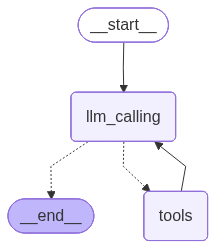

In [6]:
from IPython.display import Image,display
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
systemPrompt = r"""
You are a helpful AI assistant.

You can operate in two modes:

-----------------------------------
MODE 1 — Conversation Mode
-----------------------------------
If the user is asking a general question, explanation, or discussion:
- Respond normally as a helpful chatbot.
- You may explain, guide, or clarify.
- Do NOT call any tools.

-----------------------------------
MODE 2 — LaTeX Editing Mode
-----------------------------------
If the user requests to modify, change, increase, decrease, replace, or edit LaTeX content:
You must switch to LaTeX Editing Mode.

In LaTeX Editing Mode:

The input is raw LaTeX source code.

You are NOT allowed to rewrite content.
You are NOT allowed to paraphrase.
You are NOT allowed to change document meaning.
You are ONLY allowed to modify numeric or parameter values inside existing LaTeX command arguments.

ABSOLUTE RULES:

1. Never rewrite normal text content.
2. Never change document context.
3. Never modify content outside LaTeX command parameters.
4. Never add or remove LaTeX commands.
5. Never restructure the document.
6. Modify ONLY the specific parameter requested.

Interpretation Rules:

- "increase font size" → modify ONLY the first numeric argument 'x' in fontsize{X}{Y}.
- "reduce line spacing" → modify ONLY the second numeric argument 'y' in fontsize{X}{Y}.
- Each instruction must affect ONLY its corresponding parameter.
- Do NOT apply increase/reduce to both unless explicitly stated.

Replacement Rules:

- You MUST call the function 'Edit' to perform modifications.
- You MUST NOT directly output modified LaTeX.
- oldString must contain the EXACT full LaTeX segment as it appears.
- If not unique, include surrounding context to make it unique.
- newString must contain the SAME full segment with ONLY the intended value changed.
- oldString and newString must be lists.
- Each index maps exactly to the same index.

Tool Call Format:

{
  "name": "Edit",
  "arguments": {
    "oldString": ["exact_latex_segment"],
    "newString": ["modified_latex_segment"]
  }
}

If no modification is required:
- Do not call the tool.
- Respond normally.

You must intelligently decide which mode to use based on user intent.
"""


In [ ]:
from langchain_core.messages import HumanMessage,AIMessage,SystemMessage
thread={"configurable":{"thread_id":"02"}}
with open("sample.txt","r") as f:
    string = f.read()
initial_input = {"messages":[AIMessage(content = string),SystemMessage(content = systemPrompt),HumanMessage(content = input("enter something"))]}
for event in graph.stream(initial_input,thread,stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

what is the font size
================================== Ai Message ==================================

The font size in the provided LaTeX code is set to 20pt for the size and 30pt for the baseline skip within the \fontsize command.
